**Importing dataset**

In [ ]:
!unzip -q MRI.zip -d dataset

In [ ]:
!ls dataset

brain_tumor_dataset  no  yes


**Preprocessing images**

In [ ]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

def preprocess_images(folder_path, size=(128, 128)):
    images = []
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(size, Image.ANTIALIAS)
        img_np = np.array(img, dtype=np.float32) / 255.0  # Normalize
        images.append(img_np.flatten())  # Flatten and store
    return np.array(images)

# 'yes' and 'no' folders are directly inside 'dataset'
yes_images = preprocess_images('dataset/yes')
no_images = preprocess_images('dataset/no')


  0%|          | 0/155 [00:00<?, ?it/s]<ipython-input-3-7f46d793dde8>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)
100%|██████████| 98/98 [00:00<00:00, 394.56it/s]


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as transforms
import torch

**Prepare data for the model**

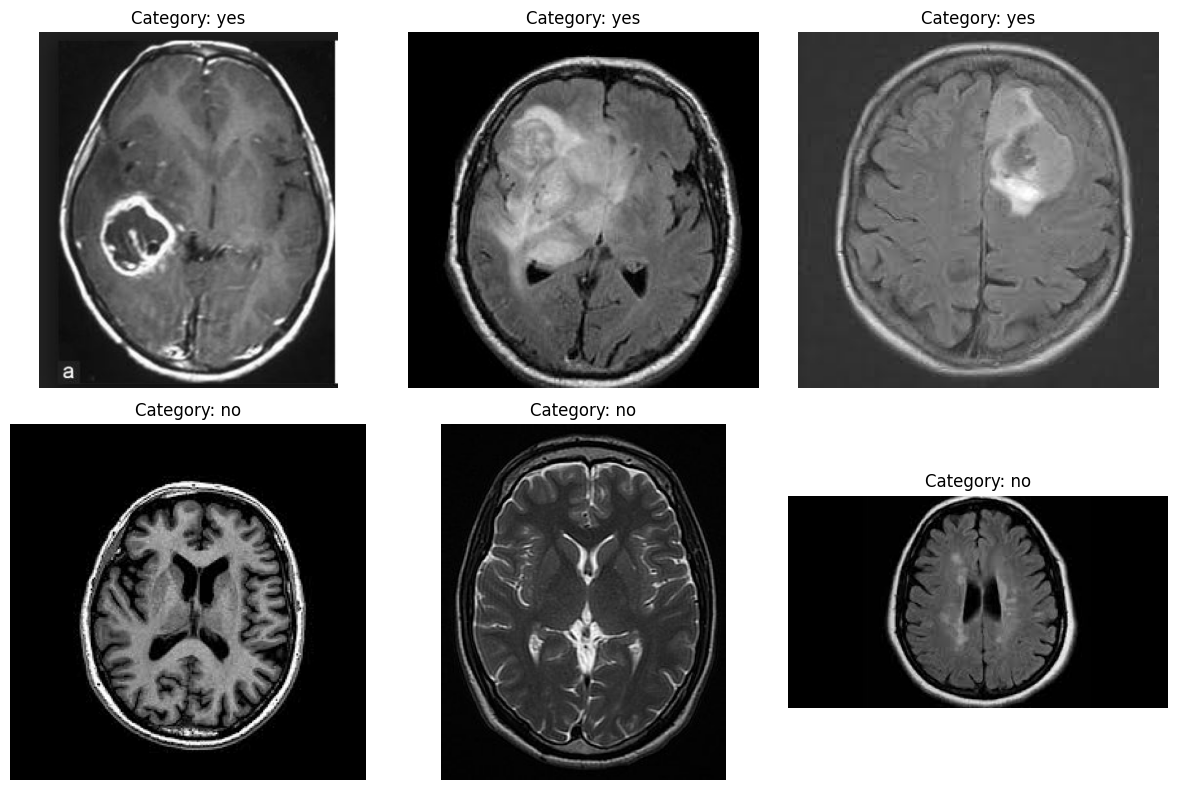

In [ ]:
def load_image_as_tensor(image_path):
    img = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    tensor_img = transform(img)
    return tensor_img

def display_sample_images(base_dir, num_samples=3):

    categories = ['yes', 'no']
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 4, len(categories) * 4))

    for i, category in enumerate(categories):
        category_dir = os.path.join(base_dir, category)
        sample_images = os.listdir(category_dir)[:num_samples]
        for j, image_name in enumerate(sample_images):
            image_path = os.path.join(category_dir, image_name)
            tensor_img = load_image_as_tensor(image_path)
            img = transforms.ToPILImage()(tensor_img).convert("RGB")
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Category: {category}")

    plt.tight_layout()
    plt.show()

base_dir = 'dataset/brain_tumor_dataset'
display_sample_images(base_dir, num_samples=3)

**KMeans algorithm**

In [2]:
%%writefile KMeans.cu
extern "C" {
#include <iostream>
#include <cmath>
#include <float.h>
#include <cuda_runtime.h>

__global__ void assignClusters(float *data, float *centroids, int *assignments, int numPoints, int numCentroids, int dimensions) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    if (idx < numPoints) {
        float minDist = FLT_MAX;
        int minIdx = 0;
        for (int c = 0; c < numCentroids; ++c) {
            float dist = 0.0;
            for (int d = 0; d < dimensions; ++d) {
                float diff = data[idx * dimensions + d] - centroids[c * dimensions + d];
                dist += diff * diff;
            }
            if (dist < minDist) {
                minDist = dist;
                minIdx = c;
            }
        }
        assignments[idx] = minIdx;
    }
}

__global__ void updateCentroids(float *data, float *centroids, int *assignments, int *counts, int numPoints, int numCentroids, int dimensions) {
    extern __shared__ float sharedData[];
    int idx = blockDim.x * blockIdx.x + threadIdx.x;

    if (idx < numCentroids) {
        for (int d = 0; d < dimensions; ++d) {
            sharedData[idx * dimensions + d] = 0;
        }
        counts[idx] = 0;
    }
    __syncthreads();

    if (idx < numPoints) {
        int clusterId = assignments[idx];
        atomicAdd(&counts[clusterId], 1);
        for (int d = 0; d < dimensions; ++d) {
            atomicAdd(&sharedData[clusterId * dimensions + d], data[idx * dimensions + d]);
        }
    }
    __syncthreads();

    if (idx < numCentroids) {
        for (int d = 0; d < dimensions; ++d) {
            centroids[idx * dimensions + d] = sharedData[idx * dimensions + d] / counts[idx];
        }
    }
}

// Host function to call kernels
void kmeans(float *h_data, int numPoints, int dimensions, int numCentroids, int maxIterations) {
    float *d_data, *d_centroids;
    int *d_assignments, *d_counts;
    // Allocate device memory and copy data from host to device

    // Initialize centroids (possibly on the host and copy to device)

    for (int i = 0; i < maxIterations; ++i) {
        assignClusters<<<(numPoints + 255) / 256, 256>>>(d_data, d_centroids, d_assignments, numPoints, numCentroids, dimensions);
        cudaDeviceSynchronize();
        updateCentroids<<<(numCentroids + 255) / 256, 256, numCentroids * dimensions * sizeof(float)>>>(d_data, d_centroids, d_assignments, d_counts, numPoints, numCentroids, dimensions);
        cudaDeviceSynchronize();

    }

}

int main() {
    // Prepare data and call kmeans()
        switch (option)
    {
    case 1:
        train();
        break;

    case 2:
        test();
        break;

    default:
        test();

    }
    return 0;
}

}


Writing KMeans.cu


In [ ]:
!pwd

/content


In [ ]:
!ls

cuda_programs  dataset	kmeans.cu  MRI.zip  sample_data


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
from google.colab import files
files.download('kmeans.cu')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Sun Apr 14 12:15:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    121MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--